#**Final Project - DDPG**

###Import and install all necessary libraries and packages

In [1]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl
!pip3 install box2d-py
!apt-get install -y xvfb python-opengl ffmpeg
!pip -q install pyglet
!pip -q install pyopengl
!pip install gym pyvirtualdisplay
!pip3 install pybullet --upgrade
!pip3 install stable_baselines --upgrade

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [2]:
"""ENVIRONMENT"""
import gym                                                                      #OpenAI gym 
import pybullet_envs as pe
gym.logger.set_level(40)                                                        #suppresses warning messages, displays only error messages

"""MODELS AND TOOLS FOR OPTIMIZATION AND OTHER COMPUTATIONS"""
import time
import numpy as np
import torch                                                                    #will use PyTorch to handle the NN 
import torch.nn as nn                                                           #contains various NN layers
import torch.nn.functional as F                                                 #includes various functions such as convolution etc.
import torch.optim as optim                                                     #contains various optimization algorithms
import random
from random import sample,choices
from collections import deque

"""VISUALIZATION"""
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

"""I/O"""
import os
from pathlib import Path

###Display for visualization

In [3]:
display=Display(visible=0,size=(1400,900))
display.start()

def show_video(path):
    html=[]
    for mp4 in Path(path).glob("*.mp4"):
        video_b64=base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4,video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

### Some useful functions

In [4]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
  """
  Save a model to a file in your colab space 
  
  Parameters
  ----------
  model: your policy network
  filename: the name of the checkpoint file
  mode (int): determines where to store the file
  --> 0: collab space 1: Google Drive
  """
  if mode==1: 
    drive.mount('/content/gdrive')
    path=F"/content/gdrive/My Drive/{filename}" 
    torch.save(model.state_dict(),path)
  else:torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
  """
  Download a file to your local machine 
        
  Parameters
  ----------
  filename: the name of the file
  """
  files.download(filename)

###DDPG - CartPole
Use DDPG to solve the CartPole environment and enable the agent to stay upright.

Test the environment

In [ ]:
env=gym.make('CartPoleContinuousBulletEnv-v0')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
s,terminal=env.reset(),False
reward=0
while not terminal:
  action=env.action_space.sample()
  s,r,terminal,info=env.step(action)
  reward+=r
env.close()
print('Reward: '+str(reward))
show_video('./video')

Reward: 28.0


Exception ignored in: <function Monitor.__del__ at 0x7f874126b170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 137, in close
    self._close_video_recorder()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 209, in _close_video_recorder
    self.video_recorder.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 129, in close
    os.remove(self.path)
FileNotFoundError: [Errno 2] No such file or directory: '/content/video/openaigym.video.13.72.video000000.mp4'


In [ ]:
print('Observation space:',env.observation_space)
print('Action space:',env.action_space)
print('Reward threshold:',env.spec.reward_threshold)
del env

Observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space: Box(-10.0, 10.0, (1,), float32)
Reward threshold: 190.0


The algorithm

Episode#: 1	Experience#: 16	Evaluation score: 30.00	Mean training reward (last 100 episodes): 16.00	Mean evaluation reward (last 100 RO): 30.00
Episode#: 2	Experience#: 28	Evaluation score: 55.00	Mean training reward (last 100 episodes): 14.00	Mean evaluation reward (last 100 RO): 42.50
Episode#: 3	Experience#: 41	Evaluation score: 44.00	Mean training reward (last 100 episodes): 13.67	Mean evaluation reward (last 100 RO): 43.00
Episode#: 4	Experience#: 61	Evaluation score: 49.00	Mean training reward (last 100 episodes): 15.25	Mean evaluation reward (last 100 RO): 44.50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Streaming output truncated to the last 5000 lines.
Episode#: 1914	Experience#: 28479	Evaluation score: 200.00	Mean training reward (last 100 episodes): 10.87	Mean evaluation reward (last 100 RO): 127.30
Episode#: 1915	Experience#: 28492	Evaluation score: 118.00	Mean training reward (last 100 episodes): 10.41	Mean evaluation reward (last 100 RO): 126.48
Episode#: 1916	Experience#: 28505	Evaluation score: 114.00	Mean training reward (last 100 episodes): 10.37	Mean evaluation reward (last 100 RO): 126.79
Episode#: 1917	Experience#: 28520	Evaluation score: 182.00	Mean training reward (last 100 episodes): 9.86	Mean evaluation reward (last 100 RO): 127.81
Episode#: 1918	Experience#: 28533	Evaluation score: 79.00	Mean training reward (last 100 episodes): 9.78	Mean evaluation reward (last 100 RO): 127.49
Episode#: 1919	Experience#: 28546	Evaluation score: 75.00	Mean training reward (last 100 episodes): 9.76	Mean evaluation reward (last 100 RO): 127.43
Episode#: 1920	Experience#: 28558	Evaluati

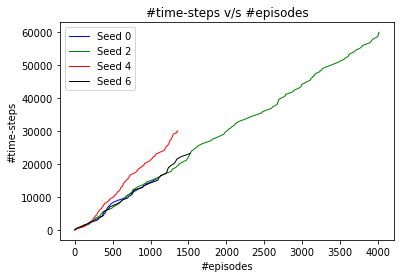

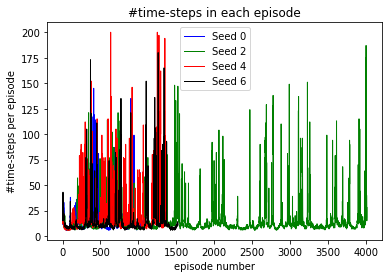

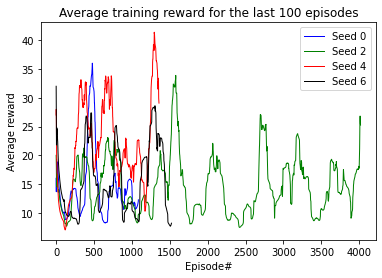

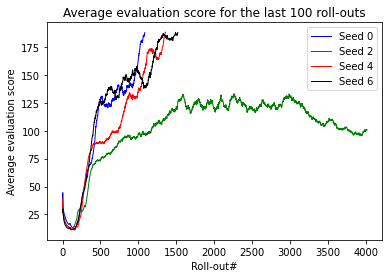

In [ ]:
"""SWITCH TO A GPU IF ONE IS AVAILABLE"""
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE POLICY (OR ACTOR) NETWORK μ"""
class Actor(nn.Module):
  def __init__(self,observations,actions,hu1,hu2,hu3):                          #actor's network architecture
    super(Actor, self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is fully-connected with #I/P=observations and #hidden units=hu1    
    self.bn1=nn.LayerNorm(hu1)                                                  #batch-normalization layer of layer1
    self.l2=nn.Linear(hu1,hu2)                                                  #layer2 is fully-connected with #I/P=hu1 and #hidden units=hu2
    self.bn2=nn.LayerNorm(hu2)                                                  #batch-normalization layer of layer2
    self.l3=nn.Linear(hu2,actions)                                              #layer3 is fully-connected with #I/P=hu2 and #O/P units=actions
    #initialize interconnection and bias weights using samples drawn from a
    #unifrom distribution with parameters 'a' and 'b'
    limit=1/np.sqrt(self.l1.weight.data.size()[0])
    torch.nn.init.uniform_(self.l1.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l1.bias.data,a=-limit,b=limit)
    limit=1/np.sqrt(self.l2.weight.data.size()[0])
    torch.nn.init.uniform_(self.l2.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l2.bias.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l3.weight.data,a=-3e-3,b=3e-3)
    torch.nn.init.uniform_(self.l3.bias.data,a=-3e-3,b=3e-3)
        
  def forward(self,x):                                                          #forward propagation
    if not isinstance(x,torch.Tensor):                                          #check if I/P is a tensor or not. If not, convert it one, and move it to 'device'
      x=torch.tensor(x,device=device,dtype=torch.float32)
      x=x.unsqueeze(0)
    x=F.relu(self.bn1(self.l1(x)))
    x=F.relu(self.bn2(self.l2(x)))
    x=torch.tanh(self.l3(x))
    return x
        


"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE VALUE-FUNCTION (OR CRITIC) NETWORK Q"""
class Critic(nn.Module):
  def __init__(self,observations,actions,hu1,hu2,hu3):                          #critic's network architecture; actor's O/P is embedded with the second hidden layer
    super(Critic, self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is fully-connected with #I/P=observations and #hidden units=hu1    
    self.bn1=nn.LayerNorm(hu1)                                                  #batch-normalization layer of layer1
    self.embed=nn.Linear(actions,hu2)                                           #embed layer embeds actor's O/P
    self.l2=nn.Linear(hu1,hu2)                                                  #layer2 is fully-connected with #I/P=hu1 and #hidden units=hu2
    self.bn2=nn.LayerNorm(hu2)                                                  #batch-normalization layer of layer2
    self.l3=nn.Linear(hu2,1)                                                    #layer3 is fully-connected layer with #I/P=hu2 and #O/P units=1 (as value-function of any state is a scalar)
    #initialize interconnection and bias weights using samples drawn from a
    #unifrom distribution with parameters 'a' and 'b'
    limit=1/np.sqrt(self.l1.weight.data.size()[0])
    torch.nn.init.uniform_(self.l1.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l1.bias.data,a=-limit,b=limit)
    limit=1/np.sqrt(self.l2.weight.data.size()[0])
    torch.nn.init.uniform_(self.l2.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l2.bias.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l3.weight.data,a=-3e-3,b=3e-3)
    torch.nn.init.uniform_(self.l3.bias.data,a=-3e-3,b=3e-3)
             
  def forward(self,x,action):                                                   #forward propagation
    if not isinstance(x,torch.Tensor):                                          #check if I/P is a tensor or not. If not, convert it one, and move it to 'device'
      x=torch.tensor(x,device=device,dtype=torch.float32)
      x=x.unsqueeze(0)
    x=F.relu(self.bn1(self.l1(x)))
    x=self.bn2(self.l2(x))
    embedOP=F.relu(self.embed((action)))                                        #embed layer positioned between hidden layers 1 and 2; it's O/P dimension same as O/P dimension of layer 2
    x=F.relu(torch.add(x,embedOP))                                              #O/Ps of embed layer and layer 2 are of same size. Embed them using elment-wise addition and pass sum to squashing function
    x=self.l3(x)  
    return x



"""ORNSTEIN-ULHENBECK PROCESS NOISE"""
#dxt=-θ(μ-xt)dt+σdWt: θ and μ are different from θ and μ of DDPG
class OUNoise(object):
  def __init__(self,actions,theta,dt,sigma):
    self.theta,self.dt,self.sigma=theta,dt,sigma
    self.mu=self.xtm1=np.zeros(actions)                                         #initialize μ and initial noise state 'xt-1'
        
  def perturb(self):                                                            #updates noise state 'xt'
    dxt=(self.theta*(self.mu-self.xtm1)*self.dt)+(self.sigma*np.sqrt(self.dt)*np.random.normal(size=self.mu.shape))
    xt=self.xtm1+dxt                                                            #new state xt=(xt-1)+dxt
    self.xtm1=xt                                                                #update 'xt-1' to 'xt'
    return xt



"""DEFINITION OF THE CHARACTERISTICS AND ATTRIBUTES OF THE DDPG AGENT"""
class DDPGagent():
  def __init__(self,observations,actions,huA1,huA2,huA3,huC1,huC2,huC3,alphaA,
               alphaC,theta,dt,sigma):
    self.actions=actions   
    self.actor=Actor(observations,actions,huA1,huA2,huA3).to(device)            #define actor (or policy) network μ, initialize its weights θ randomly, and move the network to the GPU
    self.actorTarget=Actor(observations,actions,huA1,huA2,huA3).to(device)      #define target actor (or policy) network μ- and move it to the GPU
    self.actorTarget.load_state_dict(self.actor.state_dict())                   #initialize weights θ- of μ- to θ
    self.actorOptimizer=optim.Adam(self.actor.parameters(),lr=alphaA)           #optimizer to update the weights θ of μ
    self.critic=Critic(observations,actions,huC1,huC2,huC3).to(device)          #define critic NN Q, initialize its weights φ randomly, and move the network to the GPU
    self.criticTarget=Critic(observations,actions,huC1,huC2,huC3).to(device)    #define target critic NN Q- and move it to the GPU
    self.criticTarget.load_state_dict(self.critic.state_dict())                 #initialize weights φ- of Q- to φ
    self.criticOptimizer=optim.Adam(self.critic.parameters(),lr=alphaC)         #optimizer to update the weights φ of Q
    self.noise=OUNoise(actions,theta,dt,sigma)                                  #OU noise object

  def train(self,env,seed,batchSize,epochs,gamma,maxSteps,taw,qLength,threshold):
    torch.manual_seed(seed) 
    np.random.seed(seed)
    random.seed(seed)
    self.gamma=gamma
    self.episodeReward,episodeEvaluationScore=[],[]                             #stores reward R(τ) and mean evaluation score of roll-outs corresponding to each collected τ (or episode)
    results=[]                                                                  #stores consolidated results of training
    self.D=deque(maxlen=qLength)                                                #declare experience replay buffer and define its maximum length
    numExperiences,numEpisodes=0,0                                              #keep track of #experiences and #episodes collected so far
    while numExperiences<maxSteps:
      s,terminal=env.reset(),False                                              #reset the environment at the start of each episode and set the flag 'terminal' to False
      numEpisodeSteps=0                                                         #keeps track of #time-steps in each episode
      self.episodeReward.append(0.0)                                            #episode reward at the start of an episode is 0
      while not terminal:
        sP,terminal=self.collectExperience(env,s)                               #collect an experience
        numExperiences+=1                                                       #increment every time an experience is collected
        numEpisodeSteps+=1                                                      #increment every time an experience is collected
        s=sP
        if numExperiences>=maxSteps:break                                       #loop breaks if #experiences collected so far exceeds 'maxSteps'
        if len(self.D)>=batchSize:                                              #batches sampled from replay buffer only if #elements in buffer exceeds batch size
          for epoch in range(epochs):                                           #runs multiple training epochs
            batch=choices(self.D,k=batchSize)                                   #randomly sample a mini-batch of experiences with replacement from replay buffer
            batch=np.array(batch)
            batch=[np.vstack(exp) for exp in batch.T]
            sBatch,aBatch,rBatch,sPBatch,isFailureBatch=batch
            sBatch=torch.from_numpy(sBatch).float().to(device)                  #convert experience variables to tensors and move them to the GPU
            aBatch=torch.from_numpy(aBatch).float().to(device)
            rBatch=torch.from_numpy(rBatch).float().to(device)
            sPBatch=torch.from_numpy(sPBatch).float().to(device)
            isFailureBatch=torch.from_numpy(isFailureBatch).float().to(device)
            self.learn(sBatch,aBatch,rBatch,sPBatch,isFailureBatch)             #use selected mini-batch to train actor and critic
            #soft update (Polyask averaging) of the weights of the target actor: θ-=τθ-+(1-τ)θ
            weightCopyActor=dict(self.actor.named_parameters())                 #make copies of actor and actor target weights
            weightCopyActorTarget=dict(self.actorTarget.named_parameters())
            for weight in list(self.actor.state_dict().keys()):
              weightCopyActorTarget[weight]=(taw*weightCopyActorTarget[weight].clone())+((1-taw)*weightCopyActor[weight].clone())
            self.actorTarget.load_state_dict(weightCopyActorTarget)    
            #soft update (Polyask averaging) of the weights of the target critic: φ-=τφ-+(1-τ)φ
            weightCopyCritic=dict(self.critic.named_parameters())               #make copies of critic and critic target weights
            weightCopyCriticTarget=dict(self.criticTarget.named_parameters())
            for weight in list(self.critic.state_dict().keys()):
              weightCopyCriticTarget[weight]=(taw*weightCopyCriticTarget[weight].clone())+((1-taw)*weightCopyCritic[weight].clone())
            self.criticTarget.load_state_dict(weightCopyCriticTarget)
      numEpisodes+=1                                                            #increment every time an episode terminates
      evalScore=self.evaluate(env)                                              #perform a roll-out at the end of an episode
      episodeEvaluationScore.append(evalScore)                                  #add the evaluation score of the roll-out to the list 'episodeEvaluationScore'
      mean100EpisodeReward=np.mean(self.episodeReward[-100:])                   #mean reward of the last 100 episodes
      mean100ROEvalScore=np.mean(episodeEvaluationScore[-100:])                 #mean evaluation scores of the last 100 roll-outs
      results.append((numExperiences,numEpisodeSteps,numEpisodes,
                      mean100EpisodeReward,mean100ROEvalScore))                 #add all results of the last trajectory to the list 'results'
      print('Episode#: {:d}\tExperience#: {:d}\tEvaluation score: {:.2f}\tMean training reward (last 100 episodes): {:.2f}\tMean evaluation reward (last 100 RO): {:.2f}'.format(numEpisodes,numExperiences,evalScore,mean100EpisodeReward,mean100ROEvalScore))
      if np.mean(episodeEvaluationScore[-75:])>=threshold:                      #break if mean evaluation score of last 75 roll-outs>threhsold
        print('\nThreshold evaluation score reached. Problem sovled!!\n\n')
        break
    return self.actor,self.critic,results

  def collectExperience(self,env,s):                                            #this function collects an experience
    self.actor.eval()
    a=self.exploration(s)                                                       #get an action from the actor. No need to take argmax since there is only one action which is continuous. Therefore, μ=a
    sP,r,terminal,info=env.step(10*a)
    isTruncated='TimeLimit.truncated' in info and info['TimeLimit.truncated']
    isFailure=terminal and not isTruncated
    self.D.append((s,a,r,sP,float(isFailure)))
    self.episodeReward[-1]+=r
    return sP,terminal

  def exploration(self,s):                                                      #this function gets an action from the actor and then perturbs it by adding a noise ε  
    s=torch.tensor(s).type(torch.FloatTensor).to(device)
    with torch.no_grad():
      mu=self.actor(s).cpu().detach().data.numpy().squeeze()                    #forward propagate 's' through the actor NN to obtain μθ(s)
    mu=mu+self.noise.perturb()                                                  #add OU noise ε to perturb μθ(s)
    return mu

  def learn(self,sBatch,aBatch,rBatch,sPBatch,isFailureBatch):                  #this function trains the actor and the critic
    #update weights φ of the critic
    self.actorTarget.eval()                                                     #turn off internal switch for batch-normalization layers as actor target, critic, and critic target are not trained
    self.critic.eval()
    self.criticTarget.eval()
    musPThetaMinus=self.actorTarget(sPBatch)                                    #μ(sP;θ-) of all experiences in the batch
    Q=self.criticTarget(sPBatch,musPThetaMinus)
    target=rBatch+(self.gamma*Q*(1-isFailureBatch)) 
    target=target.type(torch.FloatTensor).to(device)
    prediction=self.critic(sBatch,aBatch)                                       #prediction Q(s,a,φ)  
    self.critic.train()                                                         #turn on internal switch as critic will now be trained
    lossC=F.mse_loss(prediction,target)                                         #MSE between prediction and target
    self.criticOptimizer.zero_grad()                                            #set all gradients to 0 before backpropagation begins
    lossC.backward()                                                            #backpropagate the error
    self.criticOptimizer.step()                                                 #optimize weights using backpropagated error   
    #update weights θ of the actor
    self.critic.eval()                                                          #turn off internal switch for batch-normalization layers as critic will not be trained
    musTheta=self.actor(sBatch)                                                 #μ(s;θ) of all experiences in batch
    self.actor.train()                                                          #turn on internal switch as actor will now be trained
    Q=-self.critic(sBatch,musTheta)                                             #add a -tive sign since we perform gradient ascent to update the weights of the actor NN
    lossA=Q.mean()                                                              #average of all 'Q' of the batch is the loss
    self.actorOptimizer.zero_grad()                                             #set all gradients to 0 before backpropagation begins
    lossA.backward()                                                            #backpropagate the loss
    self.actorOptimizer.step()                                                  #optimize weights using the backpropagated loss

  def evaluate(self,env,rollOuts=1):                                            #this function executess a fixed #roll-outs at the end of each training episode
    rewards=[]
    for rollOut in range(rollOuts):
      rewards.append(0.0)
      s,terminal=env.reset(),False
      while not terminal:
        s=torch.tensor(s).float().to(device)
        a=self.greedy(s)
        s,r,terminal,_=env.step(a*10)
        rewards[-1]+=r
    self.actor.train()
    return np.mean(rewards)

  def greedy(self,s):                                                           #this function returns the action that is greedy wrt to μ(s;θ) of state 's'
    self.actor.eval()                                                           #turn off internal switch for batch-normalization layers during evaluation
    with torch.no_grad():                                                       #turn off gradient computation since actor O/P used for evaluation
      return self.actor(s).cpu().detach().data.numpy()



"""DEFINE THE ENVIRONMENT, THE PARAMETERS OF THE AGENT AND THE HYPERPARAMETERS
OF THE NEURAL NETWORK"""
env=gym.make('CartPoleContinuousBulletEnv-v0')                                  #declare the environment
seeds=[0,2,4,6]                                                                 #seeds used to randomly initialize network weights, the environment and various random functions
huA1,huA2,huA3=60,60,30                                                         ##units in first, second and third hidden layer of the actor (or policy) network μ
huC1,huC2,huC3=60,60,30                                                         ##units in first, second and third hidden layer of the critic network Q
batchSize=64                                                                    #mini-batch size
epochs=1                                                                        ##training epochs
alphaA,alphaC=3e-5,3e-4                                                         #learning rates of actor and critic
gamma=.99                                                                       #discount factor
maxSteps=60000                                                                  #maximum time-steps (or experiences) for which agent acts in the world
taw=0.99                                                                        #for Polyak (or soft) update of weights of two target networks
qLength=60000                                                                   #size of experience replay buffer
theta,dt,sigma=0.15,0.01,0.3                                                    #OU noise parameters
observations,actions=env.observation_space.shape[0],env.action_space.shape[0]   ##observations (or I/P features) and #actions
threshold=env.spec.reward_threshold                                             #threshold reward to be reached to consider the problem as solved



"""DDPG"""
results=[]
fileActor=['actorS1','actorS2','actorS3','actorS4']
fileCritic=['criticS1','criticS2','criticS3','criticS4']
for seed,fileA,fileC in zip(seeds,fileActor,fileCritic):
  env.seed(seed)                                                                #set seed for environment
  agent=DDPGagent(observations,actions,huA1,huA2,huA3,huC1,huC2,huC3,alphaA,
                  alphaC,theta,dt,sigma)                                        #create an object of type 'DDPGagent'
  actorModel,criticModel,result=agent.train(env,seed,batchSize,epochs,gamma,
                                             maxSteps,taw,qLength,threshold)    #train the DQN agent
  save_checkpoint(actorModel,fileA,1)                                           #save actor model to drive
  save_checkpoint(criticModel,fileC,1)                                          #save critic model to drive
  results.append(result)



"""PLOT THE RESULTS"""
figure1=plt.figure()                                                            #plot #time-steps versus #episodes
axis1=figure1.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r','k']):
  numExperiences=np.array(results[index])[:,0]                                  #total #time-steps (or experiences)
  plt.plot(numExperiences,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('#time-steps')
plt.xlabel('#episodes')
axis1.set_title('#time-steps v/s #episodes')
plt.legend()
plt.show()

figure2=plt.figure()                                                            #plot #time-steps in each episode
axis2=figure2.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r','k']):
  numEpisodeSteps=np.array(results[index])[:,1]                                 ##time-steps in each episode
  plt.plot(numEpisodeSteps,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('#time-steps per episode')
plt.xlabel('episode number')
axis2.set_title('#time-steps in each episode')
plt.legend()
plt.show()

figure3=plt.figure()                                                            #plot mean reward for last 100 episodes
axis3=figure3.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r','k']):
  mean100EpisodeReward=np.array(results[index])[:,3]                            #total #episodes
  plt.plot(mean100EpisodeReward,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('Average reward')
plt.xlabel('Episode#')
axis3.set_title('Average training reward for the last 100 episodes')
plt.legend()
plt.show()

figure4=plt.figure()                                                            #plot mean evaluation score for last 100 roll-outs
axis4=figure4.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r','k']):
  mean100ROEvalScore=np.array(results[index])[:,4]                              #mean evaluation score for last 100 roll-outs
  plt.plot(mean100ROEvalScore,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('Average evaluation score')
plt.xlabel('Roll-out#')
axis4.set_title('Average evaluation score for the last 100 roll-outs')
plt.legend()
plt.show()

Test the policy

In [ ]:
"""TESTING"""
env=gym.make('CartPoleContinuousBulletEnv-v0')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
s,terminal=env.reset(),False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  a=agent.greedy(s)
  s,r,terminal,_=env.step(10*a)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')


Episode reward:200.0


###DDPG algorithm - Lunar lander
Use DDPG to solve the LunarLander environment and enable the lander to land on the landing pad.

Test the environment

In [5]:
env=gym.make('LunarLanderContinuous-v2')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
s,terminal=env.reset(),False
reward=0
while not terminal:
  action=env.action_space.sample()
  s,r,terminal,info=env.step(action)
  reward+=r
env.close()
print('Reward: '+str(reward))
show_video('./video')

Reward: -393.0647870656733


In [6]:
print('Observation space:',env.observation_space)
print('Action space:',env.action_space)
print('Reward threshold:',env.spec.reward_threshold)
del env

Observation space: Box(-inf, inf, (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)
Reward threshold: 200


The algorithm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Episode#: 1	Experience#: 108	Evaluation score: -154.32	Mean training reward (last 100 episodes): -122.31	Mean evaluation reward (last 50 RO): -154.32
Episode#: 2	Experience#: 192	Evaluation score: -98.51	Mean training reward (last 100 episodes): -138.00	Mean evaluation reward (last 50 RO): -126.42
Episode#: 3	Experience#: 258	Evaluation score: -72.58	Mean training reward (last 100 episodes): -142.96	Mean evaluation reward (last 50 RO): -108.47
Episode#: 4	Experience#: 336	Evaluation score: -386.07	Mean training reward (last 100 episodes): -107.78	Mean evaluation reward (last 50 RO): -177.87
Episode#: 5	Experience#: 402	Evaluation score: -359.07	Mean training reward (last 100 episodes): -114.15	Mean evaluation reward (last 50 RO): -214.11
Episode#: 6	Experience#: 492	Evaluation score: -449.30	Mean training reward (last 100 episodes): -114.10	Mean evaluation reward (last 50 RO): -253.31
Episode#: 7	Experience#: 596	Evaluation score: -396.03	Mean training reward (last 100 episodes): -152.

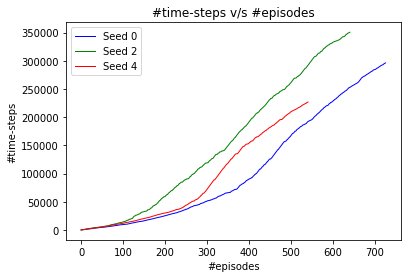

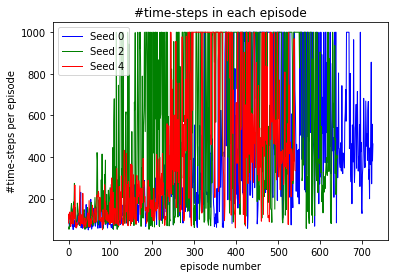

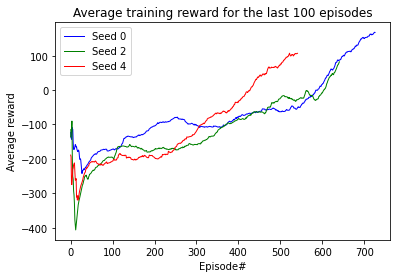

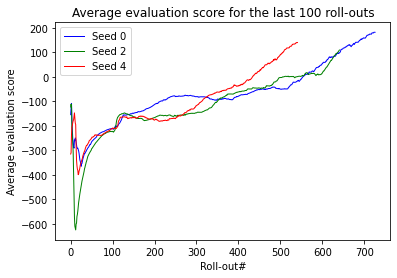

In [13]:
"""SWITCH TO A GPU IF ONE IS AVAILABLE"""
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE POLICY (OR ACTOR) NETWORK μ"""
class Actor(nn.Module):
  def __init__(self,observations,actions,hu1,hu2,hu3):                          #actor's network architecture
    super(Actor, self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is fully-connected with #I/P=observations and #hidden units=hu1    
    self.bn1=nn.LayerNorm(hu1)                                                  #batch-normalization layer of layer1
    self.l2=nn.Linear(hu1,hu2)                                                  #layer2 is fully-connected with #I/P=hu1 and #hidden units=hu2
    self.bn2=nn.LayerNorm(hu2)                                                  #batch-normalization layer of layer2
    self.l3=nn.Linear(hu2,actions)                                              #layer3 is fully-connected with #I/P=hu2 and #O/P units=actions
    #initialize interconnection and bias weights using samples drawn from a
    #unifrom distribution with parameters 'a' and 'b'
    limit=1/np.sqrt(self.l1.weight.data.size()[0])
    torch.nn.init.uniform_(self.l1.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l1.bias.data,a=-limit,b=limit)
    limit=1/np.sqrt(self.l2.weight.data.size()[0])
    torch.nn.init.uniform_(self.l2.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l2.bias.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l3.weight.data,a=-3e-3,b=3e-3)
    torch.nn.init.uniform_(self.l3.bias.data,a=-3e-3,b=3e-3)
        
  def forward(self,x):                                                          #forward propagation
    if not isinstance(x,torch.Tensor):                                          #check if I/P is a tensor or not. If not, convert it one, and move it to 'device'
      x=torch.tensor(x,device=device,dtype=torch.float32)
      x=x.unsqueeze(0)
    x=F.relu(self.bn1(self.l1(x)))
    x=F.relu(self.bn2(self.l2(x)))
    x=torch.tanh(self.l3(x))
    return x
        


"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE VALUE-FUNCTION (OR CRITIC) NETWORK Q"""
class Critic(nn.Module):
  def __init__(self,observations,actions,hu1,hu2,hu3):                          #critic's network architecture; actor's O/P is embedded with the second hidden layer
    super(Critic, self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is fully-connected with #I/P=observations and #hidden units=hu1    
    self.bn1=nn.LayerNorm(hu1)                                                  #batch-normalization layer of layer1
    self.embed=nn.Linear(actions,hu2)                                           #embed layer embeds actor's O/P
    self.l2=nn.Linear(hu1,hu2)                                                  #layer2 is fully-connected with #I/P=hu1 and #hidden units=hu2
    self.bn2=nn.LayerNorm(hu2)                                                  #batch-normalization layer of layer2
    self.l3=nn.Linear(hu2,1)                                                    #layer3 is fully-connected layer with #I/P=hu2 and #O/P units=1 (as value-function of any state is a scalar)
    #initialize interconnection and bias weights using samples drawn from a
    #unifrom distribution with parameters 'a' and 'b'
    limit=1/np.sqrt(self.l1.weight.data.size()[0])
    torch.nn.init.uniform_(self.l1.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l1.bias.data,a=-limit,b=limit)
    limit=1/np.sqrt(self.l2.weight.data.size()[0])
    torch.nn.init.uniform_(self.l2.weight.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l2.bias.data,a=-limit,b=limit)
    torch.nn.init.uniform_(self.l3.weight.data,a=-3e-3,b=3e-3)
    torch.nn.init.uniform_(self.l3.bias.data,a=-3e-3,b=3e-3)
             
  def forward(self,x,action):                                                   #forward propagation
    if not isinstance(x,torch.Tensor):                                          #check if I/P is a tensor or not. If not, convert it one, and move it to 'device'
      x=torch.tensor(x,device=device,dtype=torch.float32)
      x=x.unsqueeze(0)
    x=F.relu(self.bn1(self.l1(x)))
    x=self.bn2(self.l2(x))
    embedOP=F.relu(self.embed((action)))                                        #embed layer positioned between hidden layers 1 and 2; it's O/P dimension same as O/P dimension of layer 2
    x=F.relu(torch.add(x,embedOP))                                              #O/Ps of embed layer and layer 2 are of same size. Embed them using elment-wise addition and pass sum to squashing function
    x=self.l3(x)  
    return x



"""ORNSTEIN-ULHENBECK PROCESS NOISE"""
#dxt=-θ(μ-xt)dt+σdWt: θ and μ are different from θ and μ of DDPG
class OUNoise(object):
  def __init__(self,actions,theta,dt,sigma):
    self.theta,self.dt,self.sigma=theta,dt,sigma
    self.mu=self.xtm1=np.zeros(actions)                                         #initialize μ and initial noise state 'xt-1'
        
  def perturb(self):                                                            #updates noise state 'xt'
    dxt=(self.theta*(self.mu-self.xtm1)*self.dt)+(self.sigma*np.sqrt(self.dt)*np.random.normal(size=self.mu.shape))
    xt=self.xtm1+dxt                                                            #new state xt=(xt-1)+dxt
    self.xtm1=xt                                                                #update 'xt-1' to 'xt'
    return xt



"""DEFINITION OF THE CHARACTERISTICS AND ATTRIBUTES OF THE DDPG AGENT"""
class DDPGagent():
  def __init__(self,observations,actions,huA1,huA2,huA3,huC1,huC2,huC3,alphaA,
               alphaC,theta,dt,sigma):
    self.actions=actions   
    self.actor=Actor(observations,actions,huA1,huA2,huA3).to(device)            #define actor (or policy) network μ, initialize its weights θ randomly, and move the network to the GPU
    self.actorTarget=Actor(observations,actions,huA1,huA2,huA3).to(device)      #define target actor (or policy) network μ- and move it to the GPU
    self.actorTarget.load_state_dict(self.actor.state_dict())                   #initialize weights θ- of μ- to θ
    self.actorOptimizer=optim.Adam(self.actor.parameters(),lr=alphaA)           #optimizer to update the weights θ of μ
    self.critic=Critic(observations,actions,huC1,huC2,huC3).to(device)          #define critic NN Q, initialize its weights φ randomly, and move the network to the GPU
    self.criticTarget=Critic(observations,actions,huC1,huC2,huC3).to(device)    #define target critic NN Q- and move it to the GPU
    self.criticTarget.load_state_dict(self.critic.state_dict())                 #initialize weights φ- of Q- to φ
    self.criticOptimizer=optim.Adam(self.critic.parameters(),lr=alphaC)         #optimizer to update the weights φ of Q
    self.noise=OUNoise(actions,theta,dt,sigma)                                  #OU noise object

  def train(self,env,seed,batchSize,epochs,gamma,maxSteps,taw,qLength,threshold):
    torch.manual_seed(seed) 
    np.random.seed(seed)
    random.seed(seed)
    self.gamma=gamma
    self.episodeReward,episodeEvaluationScore=[],[]                             #stores reward R(τ) and mean evaluation score of roll-outs corresponding to each collected τ (or episode)
    results=[]                                                                  #stores consolidated results of training
    self.D=deque(maxlen=qLength)                                                #declare experience replay buffer and define its maximum length
    numExperiences,numEpisodes=0,0                                              #keep track of #experiences and #episodes collected so far
    while numExperiences<maxSteps:
      s,terminal=env.reset(),False                                              #reset the environment at the start of each episode and set the flag 'terminal' to False
      numEpisodeSteps=0                                                         #keeps track of #time-steps in each episode
      self.episodeReward.append(0.0)                                            #episode reward at the start of an episode is 0
      while not terminal:
        sP,terminal=self.collectExperience(env,s)                               #collect an experience
        numExperiences+=1                                                       #increment every time an experience is collected
        numEpisodeSteps+=1                                                      #increment every time an experience is collected
        s=sP
        if numExperiences>=maxSteps:break                                       #loop breaks if #experiences collected so far exceeds 'maxSteps'
        if len(self.D)>=batchSize:                                              #batches sampled from replay buffer only if #elements in buffer exceeds batch size
          for epoch in range(epochs):                                           #runs multiple training epochs
            batch=choices(self.D,k=batchSize)                                   #randomly sample a mini-batch of experiences with replacement from replay buffer
            batch=np.array(batch)
            batch=[np.vstack(exp) for exp in batch.T]
            sBatch,aBatch,rBatch,sPBatch,isFailureBatch=batch
            sBatch=torch.from_numpy(sBatch).float().to(device)                  #convert experience variables to tensors and move them to the GPU
            aBatch=torch.from_numpy(aBatch).float().to(device)
            rBatch=torch.from_numpy(rBatch).float().to(device)
            sPBatch=torch.from_numpy(sPBatch).float().to(device)
            isFailureBatch=torch.from_numpy(isFailureBatch).float().to(device)
            self.learn(sBatch,aBatch,rBatch,sPBatch,isFailureBatch)             #use selected mini-batch to train actor and critic
            #soft update (Polyask averaging) of the weights of the target actor: θ-=τθ-+(1-τ)θ
            weightCopyActor=dict(self.actor.named_parameters())                 #make copies of actor and actor target weights
            weightCopyActorTarget=dict(self.actorTarget.named_parameters())
            for weight in list(self.actor.state_dict().keys()):
              weightCopyActorTarget[weight]=(taw*weightCopyActorTarget[weight].clone())+((1-taw)*weightCopyActor[weight].clone())
            self.actorTarget.load_state_dict(weightCopyActorTarget)    
            #soft update (Polyask averaging) of the weights of the target critic: φ-=τφ-+(1-τ)φ
            weightCopyCritic=dict(self.critic.named_parameters())               #make copies of critic and critic target weights
            weightCopyCriticTarget=dict(self.criticTarget.named_parameters())
            for weight in list(self.critic.state_dict().keys()):
              weightCopyCriticTarget[weight]=(taw*weightCopyCriticTarget[weight].clone())+((1-taw)*weightCopyCritic[weight].clone())
            self.criticTarget.load_state_dict(weightCopyCriticTarget)
      numEpisodes+=1                                                            #increment every time an episode terminates
      evalScore=self.evaluate(env)                                              #perform a roll-out at the end of an episode
      episodeEvaluationScore.append(evalScore)                                  #add the evaluation score of the roll-out to the list 'episodeEvaluationScore'
      mean100EpisodeReward=np.mean(self.episodeReward[-100:])                   #mean reward of the last 100 episodes
      mean100ROEvalScore=np.mean(episodeEvaluationScore[-100:])                 #mean evaluation scores of the last 100 roll-outs
      results.append((numExperiences,numEpisodeSteps,numEpisodes,
                      mean100EpisodeReward,mean100ROEvalScore))                 #add all results of the last trajectory to the list 'results'
      print('Episode#: {:d}\tExperience#: {:d}\tEvaluation score: {:.2f}\tMean training reward (last 100 episodes): {:.2f}\tMean evaluation reward (last 50 RO): {:.2f}'.format(numEpisodes,numExperiences,evalScore,mean100EpisodeReward,np.mean(episodeEvaluationScore[-50:])))
      if np.mean(episodeEvaluationScore[-50:])>=threshold:
        print('\nThreshold evaluation score reached. Problem sovled!!')
        break
    return self.actor,self.critic,results

  def collectExperience(self,env,s):                                            #this function collects an experience
    self.actor.eval()
    a=self.exploration(s)                                                       #get an action from the actor. No need to take argmax since there is only one action which is continuous. Therefore, μ=a
    sP,r,terminal,info=env.step(a)
    isTruncated='TimeLimit.truncated' in info and info['TimeLimit.truncated']
    isFailure=terminal and not isTruncated
    self.D.append((s,a,r,sP,float(isFailure)))
    self.episodeReward[-1]+=r
    return sP,terminal

  def exploration(self,s):                                                      #this function gets an action from the actor and then perturbs it by adding a noise ε  
    s=torch.tensor(s).type(torch.FloatTensor).to(device)
    with torch.no_grad():
      mu=self.actor(s).cpu().detach().data.numpy().squeeze()                    #forward propagate 's' through the actor NN to obtain μθ(s)
    mu=mu+self.noise.perturb()                                                  #add OU noise ε to perturb μθ(s)
    return mu

  def learn(self,sBatch,aBatch,rBatch,sPBatch,isFailureBatch):                  #this function trains the actor and the critic
    #update weights φ of the critic
    self.actorTarget.eval()                                                     #turn off internal switch for batch-normalization layers as actor target, critic, and critic target are not trained
    self.critic.eval()
    self.criticTarget.eval()
    musPThetaMinus=self.actorTarget(sPBatch)                                    #μ(sP;θ-) of all experiences in the batch
    Q=self.criticTarget(sPBatch,musPThetaMinus)
    target=rBatch+(self.gamma*Q*(1-isFailureBatch)) 
    target=target.type(torch.FloatTensor).to(device)
    prediction=self.critic(sBatch,aBatch)                                       #prediction Q(s,a,φ)  
    self.critic.train()                                                         #turn on internal switch as critic will now be trained
    lossC=F.mse_loss(prediction,target)                                         #MSE between prediction and target
    self.criticOptimizer.zero_grad()                                            #set all gradients to 0 before backpropagation begins
    lossC.backward()                                                            #backpropagate the error
    self.criticOptimizer.step()                                                 #optimize weights using backpropagated error   
    #update weights θ of the actor
    self.critic.eval()                                                          #turn off internal switch for batch-normalization layers as critic will not be trained
    musTheta=self.actor(sBatch)                                                 #μ(s;θ) of all experiences in batch
    self.actor.train()                                                          #turn on internal switch as actor will now be trained
    Q=-self.critic(sBatch,musTheta)                                             #add a -tive sign since we perform gradient ascent to update the weights of the actor NN
    lossA=Q.mean()                                                              #average of all 'Q' of the batch is the loss
    self.actorOptimizer.zero_grad()                                             #set all gradients to 0 before backpropagation begins
    lossA.backward()                                                            #backpropagate the loss
    self.actorOptimizer.step()                                                  #optimize weights using the backpropagated loss

  def evaluate(self,env,rollOuts=1):                                            #this function executess a fixed #roll-outs at the end of each training episode
    rewards=[]
    for rollOut in range(rollOuts):
      rewards.append(0.0)
      s,terminal=env.reset(),False
      while not terminal:
        s=torch.tensor(s).float().to(device)
        a=self.greedy(s)
        s,r,terminal,_=env.step(a)
        rewards[-1]+=r
    self.actor.train()
    return np.mean(rewards)

  def greedy(self,s):                                                           #this function returns the action that is greedy wrt to μ(s;θ) of state 's'
    self.actor.eval()                                                           #turn off internal switch for batch-normalization layers during evaluation
    with torch.no_grad():                                                       #turn off gradient computation since actor O/P used for evaluation
      return self.actor(s).cpu().detach().data.numpy()



"""DEFINE THE ENVIRONMENT, THE PARAMETERS OF THE AGENT AND THE HYPERPARAMETERS
OF THE NEURAL NETWORK"""
env=gym.make('LunarLanderContinuous-v2')                                        #declare the environment
seeds=[0,2,4]                                                                   #seeds used to randomly initialize network weights, the environment and various random functions
huA1,huA2,huA3=256,256,30                                                       ##units in first, second and third hidden layer of the actor (or policy) network μ
huC1,huC2,huC3=256,256,30                                                       ##units in first, second and third hidden layer of the critic network Q
batchSize=64                                                                    #mini-batch size
epochs=1                                                                        ##training epochs
alphaA,alphaC=2.5e-5,2.5e-4                                                         #learning rates of actor and critic
gamma=.99                                                                       #discount factor
maxSteps=1000000                                                                #maximum time-steps (or experiences) for which agent acts in the world
taw=0.99                                                                        #for Polyak (or soft) update of weights of two target networks
qLength=1000000                                                                 #size of experience replay buffer
theta,dt,sigma=0.2,0.01,0.15                                                    #OU noise parameters
observations,actions=env.observation_space.shape[0],env.action_space.shape[0]   ##observations (or I/P features) and #actions
threshold=env.spec.reward_threshold                                             #threshold reward to be reached to consider the problem as solved



"""DDPG"""
results=[]
fileActor=['actorS1','actorS2','actorS3']
fileCritic=['criticS1','criticS2','criticS3']
for seed,fileA,fileC in zip(seeds,fileActor,fileCritic):
  env.seed(seed)                                                                #set seed for environment
  agent=DDPGagent(observations,actions,huA1,huA2,huA3,huC1,huC2,huC3,alphaA,
                  alphaC,theta,dt,sigma)                                        #create an object of type 'DDPGagent'
  actorModel,criticModel,result=agent.train(env,seed,batchSize,epochs,gamma,
                                             maxSteps,taw,qLength,threshold)    #train the DQN agent
  save_checkpoint(actorModel,fileA,1)                                           #save actor model to drive
  save_checkpoint(criticModel,fileC,1)                                          #save critic model to drive
  results.append(result)



"""PLOT THE RESULTS"""
figure1=plt.figure()                                                            #plot #time-steps versus #episodes
axis1=figure1.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r']):
  numExperiences=np.array(results[index])[:,0]                                  #total #time-steps (or experiences)
  plt.plot(numExperiences,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('#time-steps')
plt.xlabel('#episodes')
axis1.set_title('#time-steps v/s #episodes')
plt.legend()
plt.show()

figure2=plt.figure()                                                            #plot #time-steps in each episode
axis2=figure2.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r']):
  numEpisodeSteps=np.array(results[index])[:,1]                                 ##time-steps in each episode
  plt.plot(numEpisodeSteps,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('#time-steps per episode')
plt.xlabel('episode number')
axis2.set_title('#time-steps in each episode')
plt.legend()
plt.show()

figure3=plt.figure()                                                            #plot mean reward for last 100 episodes
axis3=figure3.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r']):
  mean100EpisodeReward=np.array(results[index])[:,3]                            #total #episodes
  plt.plot(mean100EpisodeReward,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('Average reward')
plt.xlabel('Episode#')
axis3.set_title('Average training reward for the last 100 episodes')
plt.legend()
plt.show()

figure4=plt.figure()                                                            #plot mean evaluation score for last 100 roll-outs
axis4=figure4.add_subplot(111)
for index,seed,color in zip(range(len(seeds)),seeds,['b','g','r']):
  mean100ROEvalScore=np.array(results[index])[:,4]                              #mean evaluation score for last 100 roll-outs
  plt.plot(mean100ROEvalScore,color,label='Seed '+str(seed),linewidth=1)
plt.ylabel('Average evaluation score')
plt.xlabel('Roll-out#')
axis4.set_title('Average evaluation score for the last 100 roll-outs')
plt.legend()
plt.show()

Test the policy


In [1]:
"""TESTING"""
env=gym.make('LunarLanderContinuous-v2')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
s,terminal=env.reset(),False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  a=agent.greedy(s)
  s,r,terminal,_=env.step(a)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')

NameError: ignored